# Ultrasound_Nerve_segmentation

The Purpose of this notebook is to provide a kick start for solving ultrasound nerve segmentation problems using Deep learning

This notebook depends on the data cleaned by the '0_EDA and Data Preprocessing' notebook in the same repository

We have used the popular UNet architecture (https://arxiv.org/abs/1505.04597) to try to find the segment BP nerves. At a high level below are the steps followed

1. Create a Dataloader. For creating a data loader we have rescaled the images into  (128 x 128) format. As images are in grayscale format no other augmentation is done. However based on research done by us, augmenting the images (specifically rotation ) can help in getting more accuracy
2. Create  a UNet archiecture
3. We have used Dice Loss in this case. We opted for dice loss because of following reasons

    a. Usually medical imaging problems utilise Dice Coefficient to evaluate the result
    
    b. Due to the size of the BP nerve, DICE loss would help in better handling of the class imbalance
    
    
4. Train the model. No splitting of train test is done, however we plan to do it in future
5. Evaluate the model for few images to check basic convergence. Again the objective is not to win the challenge but to learn and experiment on Unet arch
6. For post processing after segmentation, we tried with a couple of ideas like hard thresholding & PCA to better shape the masks, however the segmentation masks cannot be as accurate of shape as Human labelling


In [133]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision
import torchvision.transforms as tfms
import torch.utils.data as data
import matplotlib.pyplot as plt
import torch.nn.functional as F
import scipy as sc
import os
import PIL
import cv2
import PIL.Image as Image
%matplotlib inline

In [2]:
#HYPERPARAMS
TRAIN_PATH = r'D:\Work\DL_learn\Datasets\UltrasoundNerveSegmentation\train_cleaned'
bs = 2
num_epochs = 50
learning_rate = 1e-5

In [3]:
from sklearn.cross_validation import train_test_split

C:\Users\mohit\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data Loader 

In [4]:
class NerveDataloader(data.Dataset):
    def __init__(self,root_dir,transforms = None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.files = [x for x in os.listdir(self.root_dir) if 'mask' not in x ]
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self,idx):
        img_name = self.files[idx]
        label_name = img_name.split('.')[0] + '_mask.png'
        img = Image.open(os.path.join(self.root_dir,img_name))
        label = Image.open(os.path.join(self.root_dir,label_name))
        if self.transforms:
            img = self.transforms(img)
            label = self.transforms(label)
            return img,label
        else:
            return img, label

In [5]:
train_dataset = NerveDataloader(TRAIN_PATH, transforms=tfms.Compose([
    tfms.Resize((128,128)),
    tfms.ToTensor()
    
]))

In [6]:
train_dataset.files

['10_10.png',
 '10_102.png',
 '10_104.png',
 '10_105.png',
 '10_106.png',
 '10_108.png',
 '10_110.png',
 '10_113.png',
 '10_114.png',
 '10_115.png',
 '10_117.png',
 '10_119.png',
 '10_12.png',
 '10_14.png',
 '10_16.png',
 '10_17.png',
 '10_21.png',
 '10_22.png',
 '10_23.png',
 '10_24.png',
 '10_26.png',
 '10_27.png',
 '10_28.png',
 '10_29.png',
 '10_3.png',
 '10_30.png',
 '10_31.png',
 '10_32.png',
 '10_33.png',
 '10_34.png',
 '10_35.png',
 '10_36.png',
 '10_38.png',
 '10_39.png',
 '10_40.png',
 '10_41.png',
 '10_43.png',
 '10_45.png',
 '10_47.png',
 '10_49.png',
 '10_5.png',
 '10_51.png',
 '10_53.png',
 '10_56.png',
 '10_59.png',
 '10_6.png',
 '10_60.png',
 '10_61.png',
 '10_62.png',
 '10_63.png',
 '10_65.png',
 '10_69.png',
 '10_71.png',
 '10_72.png',
 '10_73.png',
 '10_74.png',
 '10_75.png',
 '10_76.png',
 '10_79.png',
 '10_80.png',
 '10_84.png',
 '10_86.png',
 '10_87.png',
 '10_90.png',
 '10_92.png',
 '10_93.png',
 '10_95.png',
 '10_96.png',
 '11_1.png',
 '11_100.png',
 '11_101.png

In [7]:
train_loader = data.DataLoader(train_dataset,batch_size=bs,shuffle=True)

In [42]:
img_test,lb_test = next(iter(train_loader))

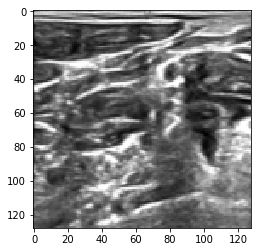

In [43]:
plt.imshow(img_test[0].squeeze(),cmap = 'gray')

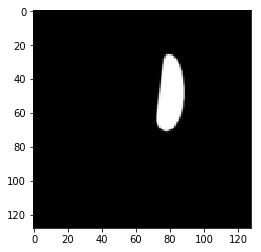

In [44]:
plt.imshow(lb_test[0].squeeze(),cmap = 'gray')

## NN Architecture

In [11]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [24]:
class UNet_model(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet_model, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def weight_init(self):
        for i,m in enumerate(self.modules()):
            if isinstance(m,nn.Conv2d):
                nn.init.xavier_normal(m.weight)
                nn.init.constant(m.bias, 0)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = F.sigmoid(x)
        return x


In [25]:
model = UNet_model(1,1).cuda()

In [26]:
model.weight_init()

C:\Users\mohit\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
C:\Users\mohit\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


In [27]:
model

UNet_model(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, ep

## Loss Function

In [28]:
class DiceCoeffLoss(nn.Module):
    def __init__(self,smooth=1):
        super(DiceCoeffLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self,input, target):
        iflat = input.view(-1)
        tflat = target.view(-1)
        intersection = (iflat * tflat).sum()
        return 1 - ((2. * intersection + self.smooth) / (iflat.sum() + tflat.sum() + self.smooth))

In [29]:
criterion = DiceCoeffLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-5)

In [30]:
#test loss
test_op = model(img_test.cuda())
criterion.forward(lb_test.cuda(),test_op)

tensor(0.9999, device='cuda:0')

## Training

In [31]:
for epoch in range(num_epochs):
    for i,(images,labels) in enumerate(train_loader):
        images = images.cuda()
        labels =labels.cuda()
        outputs = model(images)
        optimizer.zero_grad()
        loss = criterion.forward(labels,outputs)
        loss.backward()
        optimizer.step()
        del images,labels,outputs
        if i%100 == 0:
            print('Epoch [%d/%d], Step [%d/%d], Loss = %.4f' %(epoch+1, num_epochs, i+1, len(train_dataset)//bs, loss.data))

Epoch [1/50], Step [1/1953], Loss = 0.9999
Epoch [1/50], Step [101/1953], Loss = 0.9482
Epoch [1/50], Step [201/1953], Loss = 0.9429
Epoch [1/50], Step [301/1953], Loss = 0.9999
Epoch [1/50], Step [401/1953], Loss = 0.9999
Epoch [1/50], Step [501/1953], Loss = 0.9103
Epoch [1/50], Step [601/1953], Loss = 0.9999
Epoch [1/50], Step [701/1953], Loss = 0.9999
Epoch [1/50], Step [801/1953], Loss = 0.9136
Epoch [1/50], Step [901/1953], Loss = 0.9189
Epoch [1/50], Step [1001/1953], Loss = 0.9065
Epoch [1/50], Step [1101/1953], Loss = 0.9999
Epoch [1/50], Step [1201/1953], Loss = 0.9999
Epoch [1/50], Step [1301/1953], Loss = 0.9424
Epoch [1/50], Step [1401/1953], Loss = 0.9004
Epoch [1/50], Step [1501/1953], Loss = 0.8905
Epoch [1/50], Step [1601/1953], Loss = 0.9163
Epoch [1/50], Step [1701/1953], Loss = 0.9999
Epoch [1/50], Step [1801/1953], Loss = 0.9009
Epoch [1/50], Step [1901/1953], Loss = 0.9131
Epoch [2/50], Step [1/1953], Loss = 0.9999
Epoch [2/50], Step [101/1953], Loss = 0.9066
Epoc

Epoch [10/50], Step [1/1953], Loss = 0.5047
Epoch [10/50], Step [101/1953], Loss = 0.9997
Epoch [10/50], Step [201/1953], Loss = 0.9994
Epoch [10/50], Step [301/1953], Loss = 0.6268
Epoch [10/50], Step [401/1953], Loss = 0.3824
Epoch [10/50], Step [501/1953], Loss = 0.3388
Epoch [10/50], Step [601/1953], Loss = 0.5981
Epoch [10/50], Step [701/1953], Loss = 0.4920
Epoch [10/50], Step [801/1953], Loss = 0.9993
Epoch [10/50], Step [901/1953], Loss = 0.4677
Epoch [10/50], Step [1001/1953], Loss = 0.5326
Epoch [10/50], Step [1101/1953], Loss = 0.4797
Epoch [10/50], Step [1201/1953], Loss = 0.9997
Epoch [10/50], Step [1301/1953], Loss = 0.9996
Epoch [10/50], Step [1401/1953], Loss = 0.9997
Epoch [10/50], Step [1501/1953], Loss = 0.9992
Epoch [10/50], Step [1601/1953], Loss = 0.4817
Epoch [10/50], Step [1701/1953], Loss = 0.5261
Epoch [10/50], Step [1801/1953], Loss = 0.3213
Epoch [10/50], Step [1901/1953], Loss = 0.3987
Epoch [11/50], Step [1/1953], Loss = 0.9992
Epoch [11/50], Step [101/195

Epoch [18/50], Step [1601/1953], Loss = 0.9895
Epoch [18/50], Step [1701/1953], Loss = 0.0984
Epoch [18/50], Step [1801/1953], Loss = 0.1148
Epoch [18/50], Step [1901/1953], Loss = 0.1319
Epoch [19/50], Step [1/1953], Loss = 0.9889
Epoch [19/50], Step [101/1953], Loss = 0.1395
Epoch [19/50], Step [201/1953], Loss = 0.1152
Epoch [19/50], Step [301/1953], Loss = 0.9864
Epoch [19/50], Step [401/1953], Loss = 0.0842
Epoch [19/50], Step [501/1953], Loss = 0.9912
Epoch [19/50], Step [601/1953], Loss = 0.9844
Epoch [19/50], Step [701/1953], Loss = 0.9833
Epoch [19/50], Step [801/1953], Loss = 0.9838
Epoch [19/50], Step [901/1953], Loss = 0.9822
Epoch [19/50], Step [1001/1953], Loss = 0.1235
Epoch [19/50], Step [1101/1953], Loss = 0.9804
Epoch [19/50], Step [1201/1953], Loss = 0.9811
Epoch [19/50], Step [1301/1953], Loss = 0.1575
Epoch [19/50], Step [1401/1953], Loss = 0.1005
Epoch [19/50], Step [1501/1953], Loss = 0.9791
Epoch [19/50], Step [1601/1953], Loss = 0.9780
Epoch [19/50], Step [1701

Epoch [27/50], Step [1201/1953], Loss = 0.0719
Epoch [27/50], Step [1301/1953], Loss = 0.0788
Epoch [27/50], Step [1401/1953], Loss = 0.3416
Epoch [27/50], Step [1501/1953], Loss = 0.1956
Epoch [27/50], Step [1601/1953], Loss = 0.3445
Epoch [27/50], Step [1701/1953], Loss = 0.0836
Epoch [27/50], Step [1801/1953], Loss = 0.0526
Epoch [27/50], Step [1901/1953], Loss = 0.1188
Epoch [28/50], Step [1/1953], Loss = 0.3129
Epoch [28/50], Step [101/1953], Loss = 0.0707
Epoch [28/50], Step [201/1953], Loss = 0.1391
Epoch [28/50], Step [301/1953], Loss = 0.2970
Epoch [28/50], Step [401/1953], Loss = 0.0726
Epoch [28/50], Step [501/1953], Loss = 0.0749
Epoch [28/50], Step [601/1953], Loss = 0.0860
Epoch [28/50], Step [701/1953], Loss = 0.0604
Epoch [28/50], Step [801/1953], Loss = 0.1121
Epoch [28/50], Step [901/1953], Loss = 0.2740
Epoch [28/50], Step [1001/1953], Loss = 0.0701
Epoch [28/50], Step [1101/1953], Loss = 0.2564
Epoch [28/50], Step [1201/1953], Loss = 0.0633
Epoch [28/50], Step [1301

KeyboardInterrupt: 

In [32]:
#saving model
torch.save(model.state_dict(),'Unet_trial_1.pth')

In [45]:
# Train Prediction
test_op = model(img_test.cuda())

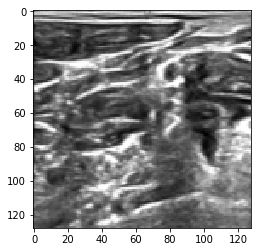

In [58]:
# Truth
plt.imshow(img_test[0].squeeze(),cmap = 'gray')

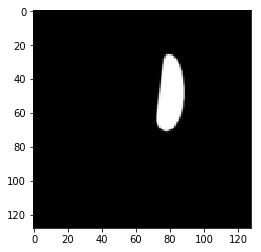

In [59]:
plt.imshow(lb_test[0].squeeze().detach(),cmap = 'gray')

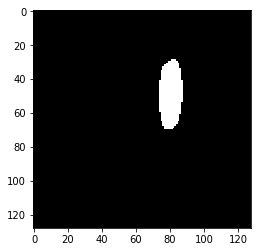

In [68]:
#Prediction
plt.imshow((test_op[0].squeeze() > 0.5).detach(),cmap = 'gray')

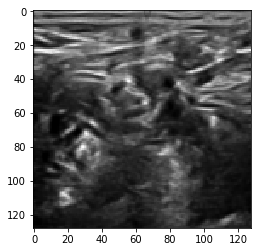

In [61]:
plt.imshow(img_test[1].squeeze(),cmap = 'gray')

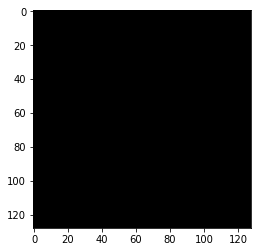

In [62]:
plt.imshow(lb_test[1].squeeze().detach(),cmap = 'gray')

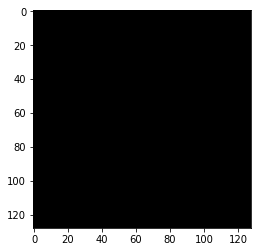

In [69]:
plt.imshow((test_op[1].squeeze() > 0.5),cmap = 'gray')

In [73]:
transforms=tfms.Compose([
    tfms.Resize((128,128)),
    tfms.ToTensor()
    
])

In [282]:
img_test = Image.open(r'D:/Work/DL_learn/Datasets/UltrasoundNerveSegmentation/train_cleaned/6_29.png')
img_test = transforms(img_test)

In [247]:
img_test.shape

torch.Size([1, 128, 128])

In [283]:
seg_pred = model(img_test.unsqueeze(0).cuda())
seg_pred = (seg_pred[0].squeeze().detach() > 0.5)

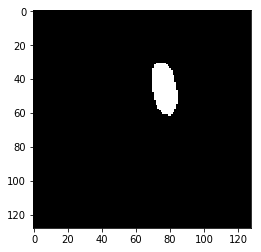

In [284]:
plt.imshow(seg_pred,cmap = 'gray')

## Postprocessing using Thresholding and PCA (WIP)

In [122]:
masks_combined = np.load('Masks_pca_data.npz')
masks_combined = masks_combined['arr_0']

In [281]:
from sklearn.decomposition import TruncatedSVD
pca2 = TruncatedSVD(n_components=20).fit(masks_combined.reshape(-1, 128*128))

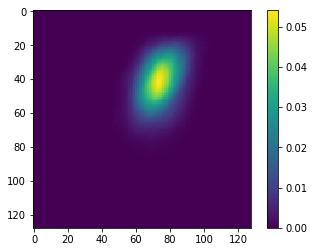

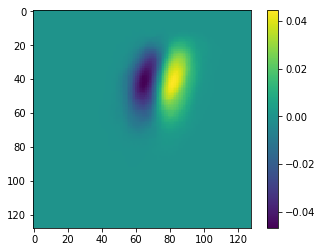

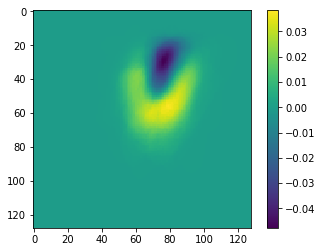

In [274]:
for i in range(pca2.components_.shape[0]):
    plt.figure()
    plt.imshow(pca2.components_[i].reshape(128, 128))
    plt.colorbar()

In [291]:
def correct_mask(test):
    test = (test > 0).astype(np.float32)
    test = pca2.transform(test.reshape(-1,128*128))
    test = pca2.inverse_transform(test).reshape(128, 128)
    return test

In [292]:
corrected_mask = correct_mask(seg_pred.detach().squeeze().cpu().numpy())

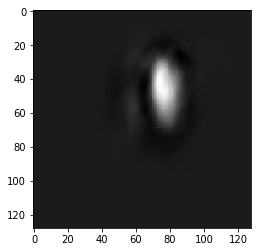

In [293]:
plt.imshow(corrected_mask,cmap = 'gray')

In [294]:
true_label = Image.open(r'D:/Work/DL_learn/Datasets/UltrasoundNerveSegmentation/train_cleaned/6_29_mask.png')
true_label = transforms(true_label)

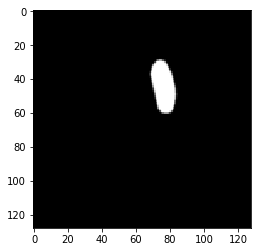

In [297]:
plt.imshow(true_label.squeeze(),cmap = 'gray')